## __GP2 Taller de Bioinformatica Mexico - DEMO 7 - Estudio de asociacion genetica__

```GP2 ❤️ Open Science 😍```

* __Modulo:__ Estudio de asociacion genetica
* __Estimacion de recursos computacionales y duracion del analisis:__
    * __Configuracion de la maquina virtual:__ 4 CPUs, 26 GB memoria, 50 GB Disco
    * __Duracion estimada:__ 1 h.
- __Fecha de ultima actualizacion:__ 13-ENERO-2023
    * Descripcion de la ultima actualizacion: 
        * Encabezado
        * Usar shell_do para crear directorio de trabajo
        * Eliminar hiperlinks

### Descripcion

__0. Getting Started__ 

- Cargar librerias de Python
- Definir funciones de Python para interactuar con GCP/Terra
- Inicializar las variables del entorno de trabajo
- Instalar paquetes

__1. Cargar los datos necesarios para realizar GWAS en el espacio de trabajo__

__2. Visualizar los datos__

__3. Control de calidad (QC)__

- Cargar librerias de Python
- Definir funciones de Python para interactuar con GCP/Terra
- Inicializar las variables del entorno de trabajo
- Instalar paquetes

__4. Estudio de asociacion (GWAS)__

- Realizar el estudio de asociacion de PD vs controles usando modelos de regresion logistica en R
- Realizar un estudio de asociacion con la edad de inicio de la enfermedad usando modelos de regresion lineal en R
- Realizar el estudio de asociacion usando plink
- Explorar resultados

__5. Visualizar los resultados__ 

- Visualizar los datos mediante un Manhattan plot
- Visualizar la validez de los resultados mediante un Q-Q plot

En este notebook vamos a realizar un estudio de asociacion del genoma completo (GWAS) con un conjunto de 66 SNPs a modo de ejemplo.  
Para ello, vamos a usar el lenguaje de programacion de Python para explorar los datos y eliminar muestras que puedan sesgar el analisis.  
Despues, vamos a usar el lenguaje de programacion de R para ajustar un modelo de regresion logistica de la misma manera que se implementa en software para analisis de datos genomicos como PLINK.  
Una vez entendido la base del analisis, vamos a descargar el software PLINK, que nos ayudara a realizar un GWAS de una manera mas automatizada.  
Finalmente, llevaremos a cabo visualizacion e interpretacion de resultados mediante tecnicas de visualizacion de GWAS muy utilizadas en la comunidad cientifica.  

## Getting Started

### Cargar librerias de Python

In [3]:
# Use the os package to interact with the environment
import os

# Use StringIO for working with file contents
from io import StringIO

# Bring in Pandas for Dataframe functionality
import pandas as pd

# numpy for basics
import numpy as np

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Import seaborn for plots
import seaborn as sns

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

### Definir funciones de Python para interactuar con GCP/Terra

In [4]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}')
    !$command

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))
    
# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

### Inicializar las variables del entorno de trabajo

In [5]:
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']
#WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

print(BILLING_PROJECT_ID)
print(WORKSPACE_NAMESPACE)
print(WORKSPACE_NAME)
print(WORKSPACE_BUCKET)

#PATH_DATOS = 'mexico-workshop'
#PATH_GWAS_DATOS = f'{PATH_DATOS}/DIA2/gwas-datos'

terra-61e6143b
GP2-Bioinformatics-Courses
GRUPO_4_MEXICO_WORKSHOP
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24


### Configurar R en el entorno de trabajo y cargar los paquetes necesarios

In [6]:
import rpy2.rinterface
%load_ext rpy2.ipython

In [7]:
%%R
print("Hello world")

[1] "Hello world"


In [8]:
%%R

pack <- "/home/jupyter/R_packages"
library(data.table, lib = pack)
library(qqman, lib= pack)
library(dplyr, lib= pack)
library(tidyr, lib.loc = pack)
library(stats)
library(ggplot2, lib= pack)

R[write to console]: data.table 1.14.6 using 16 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: 

R[write to console]: For example usage please run: vignette('qqman')

R[write to console]: 

R[write to console]: Citation appreciated but not required:

R[write to console]: Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.

R[write to console]: 

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:data.table’:

    between, first, last


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Instalar plink2

In [9]:
%%bash

mkdir -p ~/tools
cd ~/tools

echo -e "Dowloading plink2 \n    -------"
wget -N https://s3.amazonaws.com/plink2-assets/alpha3/plink2_linux_avx2_20220603.zip
unzip -o plink2_linux_avx2_20220603.zip
echo -e "\n plink2 downloaded and unzipped in /home/jupyter/tools \n "
cd ~

Dowloading plink2 
    -------
Archive:  plink2_linux_avx2_20220603.zip
  inflating: plink2                  

 plink2 downloaded and unzipped in /home/jupyter/tools 
 


--2023-01-31 16:40:27--  https://s3.amazonaws.com/plink2-assets/alpha3/plink2_linux_avx2_20220603.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.128.240, 52.216.114.53, 52.217.226.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.128.240|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘plink2_linux_avx2_20220603.zip’ not modified on server. Omitting download.



In [10]:
%%bash
ls /home/jupyter/tools/

annovar
annovar.latest.tar.gz
gcta
LICENSE
plink
plink2
plink2_linux_avx2_20220603.zip
plink_linux_x86_64_20190304.zip
prettify
toy.map
toy.ped


## Cargar los datos necesarios para realizar GWAS en el espacio de trabajo

In [11]:
# Crear una carpeta en el espacio de trabajo para copiar los archivos
print("Making a working directory")
WORK_DIR = f'/home/jupyter/workdir_GWAS'
shell_do(f'mkdir -p {WORK_DIR}')

Making a working directory
Executing: mkdir -p /home/jupyter/workdir_GWAS


In [12]:
# Explora la carpeta de gwas-datos
#gs://fc-secure-cbdcecad-15a2-473b-8df9-841de062728d
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} ls {WORKSPACE_BUCKET}')
print("\n\n Vamos a mirar que hay dentro del fichero gwas-datos \n\n")
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} ls {WORKSPACE_BUCKET}/gwas-datos')

Executing: gsutil -mu terra-61e6143b ls gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/coding_nonsynonymous_pheno_PTPA.raw
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gcta
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/pheno_PTPA_100KB.bed
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/pheno_PTPA_100KB.bim
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/pheno_PTPA_100KB.fam
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/refFlat.txt
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/sex.txt
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/EJERCICIO_1/
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/EJERCICIO_10/
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/EJERCICIO_11/
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/EJERCICIO_2/
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/EJERCICIO_3/
gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/EJERCICIO_4/
gs://fc-secure-0b3bd9f2-17a9

### Carga los datos en el entorno de trabajo

In [13]:
df = gcs_read_csv(f'{WORKSPACE_BUCKET}/gwas-datos/covariate_pheno.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   estudio            112 non-null    object 
 1   id_muestra         112 non-null    object 
 2   brazo_de_estudio   112 non-null    object 
 3   sexo               112 non-null    object 
 4   edad_inicio        41 non-null     float64
 5   historia_familiar  112 non-null    object 
 6   comienzo_estudio   112 non-null    float64
dtypes: float64(2), object(5)
memory usage: 6.2+ KB


In [14]:
df.head()


,estudio,id_muestra,brazo_de_estudio,sexo,edad_inicio,historia_familiar,comienzo_estudio
0,ESTUDIO_PD,muestra_no_1,CONTROL,Hombre,NaN,NO,78.64
1,ESTUDIO_PD,muestra_no_2,PD,Hombre,70.81,NO,76.42
2,ESTUDIO_PD,muestra_no_3,CONTROL,Hombre,NaN,NO,67.79
3,ESTUDIO_PD,muestra_no_4,PD,Mujer,58.61,NO,61.30
4,ESTUDIO_PD,muestra_no_5,PD,Mujer,52.27,NO,53.15


### Explora los datos demograficos

### Explora las variables categoricas en el conjunto de datos

In [15]:
# Contar el numero de PD y de controls, 
# Contar el numero de personas de los dos sexos
df[["sexo", "brazo_de_estudio", "historia_familiar"]].describe(include='object')

,sexo,brazo_de_estudio,historia_familiar
count,112,112,112
unique,2,2,2
top,Hombre,CONTROL,NO
freq,71,71,111


## Visualizacion de datos

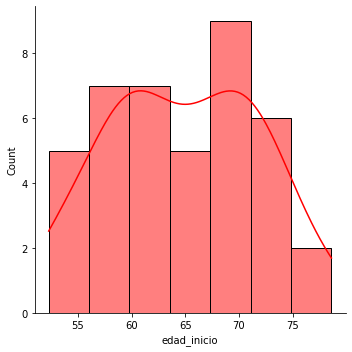

In [16]:
# Visualiza la distribucion de variables continuas
sns.displot(data = df,
            x = 'edad_inicio', 
            kde=True, 
            color = "red")

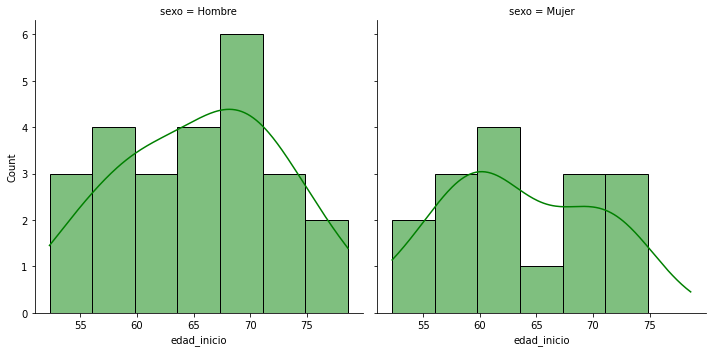

In [17]:
sns.displot(data = df,
            x = 'edad_inicio', 
            kde=True, 
            color = "green",
            col = 'sexo')

### EJERCICIO : Observa la distribucion de de edad de inicio por cada grupo de la variable genero mediante un plot violind

Para realizar este ejercicio, puedes hacer una busqueda en internet.  
**Pista**: Puedes usar el modulo seaborn (sns) que hemos usado para los plots previos. Para ello tendras que encontrar la funcion que termite obtener un violin plot

<AxesSubplot:xlabel='edad_inicio', ylabel='sexo'>

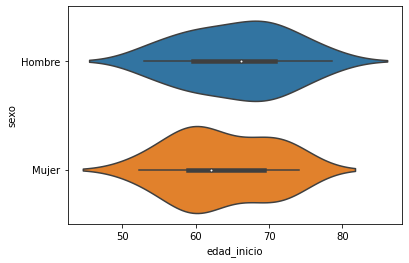

In [18]:
sns.violinplot(data=df, x='edad_inicio', y='sexo')

<AxesSubplot:xlabel='sexo', ylabel='edad_inicio'>

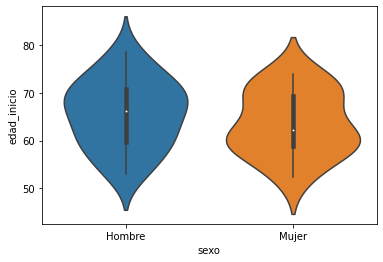

In [19]:
sns.violinplot(data=df, x='sexo', y='edad_inicio')

## Control de calidad (QC)

### Comprobar que todas las variables estan en el formato adecuado

In [20]:
print(df.sexo.unique())
print(df.brazo_de_estudio.unique())

['Hombre' 'Mujer']
['CONTROL' 'PD']


In [21]:
df['sexo'] = np.where(df['sexo'] == "Mujer", 2, 1)
df['brazo_de_estudio'] = np.where(df['brazo_de_estudio'] == "PD", 1, 0)
df.rename(columns={"brazo_de_estudio": "estado"}, inplace = True)

#https://benalexkeen.com/mapping-categorical-data-in-pandas/

In [22]:
print(df.sexo.unique())
print(df.estado.unique())

[1 2]
[0 1]


In [23]:
df.head()

,estudio,id_muestra,estado,sexo,edad_inicio,historia_familiar,comienzo_estudio
0,ESTUDIO_PD,muestra_no_1,0,1,NaN,NO,78.64
1,ESTUDIO_PD,muestra_no_2,1,1,70.81,NO,76.42
2,ESTUDIO_PD,muestra_no_3,0,1,NaN,NO,67.79
3,ESTUDIO_PD,muestra_no_4,1,2,58.61,NO,61.30
4,ESTUDIO_PD,muestra_no_5,1,2,52.27,NO,53.15


### Eliminar muestras que puedan sesgar nuestro analisis

In [24]:
df.historia_familiar.unique()

array(['NO', 'SI'], dtype=object)

In [25]:
print("Numero de muestras antes de eliminar pacientes de PD con historia familiar -> {no} \n".format(no = df.shape[0]))
     
df.drop(df[df['historia_familiar'] == "SI"].index, inplace = True)

print("Numero de muestras antes de eliminar pacientes de PD con historia familiar -> {no}".format(no = df.shape[0]))

Numero de muestras antes de eliminar pacientes de PD con historia familiar -> 112 

Numero de muestras antes de eliminar pacientes de PD con historia familiar -> 111


In [26]:
df.head()

,estudio,id_muestra,estado,sexo,edad_inicio,historia_familiar,comienzo_estudio
0,ESTUDIO_PD,muestra_no_1,0,1,NaN,NO,78.64
1,ESTUDIO_PD,muestra_no_2,1,1,70.81,NO,76.42
2,ESTUDIO_PD,muestra_no_3,0,1,NaN,NO,67.79
3,ESTUDIO_PD,muestra_no_4,1,2,58.61,NO,61.30
4,ESTUDIO_PD,muestra_no_5,1,2,52.27,NO,53.15


### Guardar los datos que pasen el control de calidad en el disco duro persistente

In [27]:
df.to_csv('/home/jupyter/workdir_GWAS/clinical_data_QC.csv', index=False) #Index=FALSE: elimina el index de la fila


## Estudio de asociacion (GWAS)

Una vez que hemos eliminado muestras que pueden sesgar nuestro analisis, recodificado variables, y explorado la distribucion de variables de interes, estamos listos para realizar el estudio de asociacion de genoma completo, tambien conocido como **GWAS**

### Copia los datos guardados en la bucket en el disco duro persistente (DP) de la maquina virtual (VM)

Antes, hemos usado Python para cargar un conjunto de datos en el entorno de trabajo (Uso de la funcion **gcs_read_csv**).  
Ahora, vamos a usar el modulo de google **gsutil** para copiar los datos de la bucket al DP

In [28]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp {WORKSPACE_BUCKET}/gwas-datos/* /home/jupyter/workdir_GWAS/')

Executing: gsutil -mu terra-61e6143b cp gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gwas-datos/* /home/jupyter/workdir_GWAS/
Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gwas-datos/covariate_pheno.csv...
Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gwas-datos/covars_plink.txt...
Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gwas-datos/genetic_data.bed...
Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gwas-datos/genetic_data.bim...
Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gwas-datos/genetic_data.fam...
Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gwas-datos/pcs_file.txt...
Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/gwas-datos/phenotype_plink.txt...
/ [7/7 files][ 27.3 KiB/ 27.3 KiB] 100% Done                                    
Operation completed over 7 objects/27.3 KiB.                                     


In [29]:
%%bash
cd /home/jupyter/workdir_GWAS/
ls

clinical_data_QC.csv
covariate_pheno.csv
covars_plink.txt
genetic_data.bed
genetic_data.bim
genetic_data.fam
genetic_Rformat.log
genetic_Rformat.raw
pcs_file.txt
phenotype_plink.txt


In [30]:
%%capture
%%bash
/home/jupyter/tools/plink2 --help 

In [31]:
shell_do(f'/home/jupyter/tools/plink2 \
            --bfile /home/jupyter/workdir_GWAS/genetic_data \
            --maf 0.01 --export A \
            --out /home/jupyter/workdir_GWAS/genetic_Rformat')

Executing: /home/jupyter/tools/plink2             --bfile /home/jupyter/workdir_GWAS/genetic_data             --maf 0.01 --export A             --out /home/jupyter/workdir_GWAS/genetic_Rformat
PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workdir_GWAS/genetic_Rformat.log.
Options in effect:
  --bfile /home/jupyter/workdir_GWAS/genetic_data
  --export A
  --maf 0.01
  --out /home/jupyter/workdir_GWAS/genetic_Rformat

Start time: Tue Jan 31 16:41:40 2023
120759 MiB RAM detected; reserving 60379 MiB for main workspace.
Using up to 32 threads (change this with --threads).
111 samples (0 females, 0 males, 111 ambiguous; 111 founders) loaded from
/home/jupyter/workdir_GWAS/genetic_data.fam.
66 variants loaded from /home/jupyter/workdir_GWAS/genetic_data.bim.
Note: No phenotype data present.
Calculating allele frequencies... done.
1 variant removed due to al

In [32]:
%%R

# Cargar los datos geneticos
cat("OBSERVA LOS DATOS GENETICOS\n\n")
datos_geneticos = fread("/home/jupyter/workdir_GWAS/genetic_Rformat.raw")
print(datos_geneticos[c(1:5), c(1:10)])

cat("\n\n OBSERVA LOS DATOS CLINICOS\n\n")

# Cargar los datos clinicos
datos_clinicos = fread("/home/jupyter/workdir_GWAS/clinical_data_QC.csv")
print(head(datos_clinicos))


datos = datos_clinicos %>% 
    inner_join(datos_geneticos, by = c("id_muestra" = "IID"))
    

# print(dim(datos))

cat("\n\n OBSERVA LOS DATOS UNIDOS \n\n")
print(datos[c(1:5), c(1:20)])

datos = datos %>%
    select(-c(FID:PHENOTYPE))

# print(datos[c(1:5), c(1:20)])

OBSERVA LOS DATOS GENETICOS

   FID          IID PAT MAT SEX PHENOTYPE rs499230_C rs647999_T rs12126052_T
1:   0 muestra_no_1   0   0   0        -9          2          1            2
2:   0 muestra_no_2   0   0   0        -9          1          1            2
3:   0 muestra_no_3   0   0   0        -9          1          2            2
4:   0 muestra_no_4   0   0   0        -9          2          2            2
5:   0 muestra_no_5   0   0   0        -9          2          2            2
   rs13031735_G
1:            2
2:            2
3:            1
4:            2
5:            2


 OBSERVA LOS DATOS CLINICOS

      estudio   id_muestra estado sexo edad_inicio historia_familiar
1: ESTUDIO_PD muestra_no_1      0    1          NA                NO
2: ESTUDIO_PD muestra_no_2      1    1       70.81                NO
3: ESTUDIO_PD muestra_no_3      0    1          NA                NO
4: ESTUDIO_PD muestra_no_4      1    2       58.61                NO
5: ESTUDIO_PD muestra_no_5      1    

### Crear un modelo de regresion logistica en R con covariables

In [33]:
%%R
# Training model
logistic_model <- glm(estado ~ comienzo_estudio + sexo, 
                      data = datos, 
                      family = "binomial")

summary(logistic_model)


Call:
glm(formula = estado ~ comienzo_estudio + sexo, family = "binomial", 
    data = datos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0894  -0.9507  -0.8923   1.3829   1.5909  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)
(Intercept)      -2.26332    2.08732  -1.084    0.278
comienzo_estudio  0.02017    0.02855   0.707    0.480
sexo              0.23215    0.41029   0.566    0.572

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 145.10  on 110  degrees of freedom
Residual deviance: 144.35  on 108  degrees of freedom
AIC: 150.35

Number of Fisher Scoring iterations: 4



### Crear el modelo de regresion logistica haciendo uso de la funcion "formula" en R

In [39]:
%%R

fmla <- formula("estado ~ comienzo_estudio + sexo")
summary(glm(fmla, data = datos, family = "binomial")) $coefficients  %>% str()

 num [1:3, 1:4] -2.2633 0.0202 0.2322 2.0873 0.0285 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:3] "(Intercept)" "comienzo_estudio" "sexo"
  ..$ : chr [1:4] "Estimate" "Std. Error" "z value" "Pr(>|z|)"


### Incorporar un bucle para incluir un SNP en cada iteracion

In [35]:
%%R
mask = grep(pattern = "^rs", x = colnames(datos))
mask
todos_snps = colnames(datos)[mask]
todos_snps


j = 0
for (SNP in todos_snps[1]) {
    j = j +1 
    print(SNP)
    fmla <- as.formula(paste("estado ~ comienzo_estudio + sexo", SNP, sep = " + "))
    model <- glm(fmla, data = datos, family = "binomial" )
    print(fmla)
    print(j)
    print(summary(model)$coefficients)
    
    
}

[1] "rs499230_C"
estado ~ comienzo_estudio + sexo + rs499230_C
[1] 1
                    Estimate Std. Error    z value  Pr(>|z|)
(Intercept)      -1.76954038 2.24296060 -0.7889307 0.4301525
comienzo_estudio  0.01952388 0.02866026  0.6812176 0.4957338
sexo              0.21733150 0.41182532  0.5277274 0.5976886
rs499230_C       -0.24414067 0.40190113 -0.6074645 0.5435427


### Realizar el paso previo en todos los SNPs e incluir la informacion en un archivo

In [36]:
%%R
mask = grep(pattern = "^rs", x = colnames(datos))
mask
todos_snps = colnames(datos)[mask]
todos_snps

coefficients<-as.data.frame(matrix(ncol= 4))
names(coefficients) <- c("SNP","Coeff", "se", "Pvalue")

j = 0
for (SNP in todos_snps) {
    j = j + 1 
    #print(SNP)
    fmla <- as.formula(paste("estado ~ comienzo_estudio + sexo", SNP, sep = " + "))
    model <- glm(fmla, data = datos, family = "binomial" )
    #print(fmla)
    #print(j)
    
    coefficients[j,1]<- SNP
    coefficients[j,2]<- summary(model)$coefficients[4,1]
    coefficients[j,3]<- summary(model)$coefficients[4,2]
    coefficients[j,4]<- summary(model)$coefficients[4,4]
}   

### Filtrar SNPs significativamente asociados

In [40]:
%%R
head(coefficients) 

           SNP        Coeff        se    Pvalue
1   rs499230_C -0.244140675 0.4019011 0.5435427
2   rs647999_T -0.005781589 0.3178598 0.9854880
3 rs12126052_T -0.589950827 0.6701157 0.3786581
4 rs13031735_G  0.379885532 0.3456180 0.2717033
5  rs9807949_G -0.693525736 0.8542200 0.4168594
6 rs12693387_T -0.351373445 0.3744333 0.3480317


In [41]:
%%R
get_index = which(coefficients$Pvalue < 0.05)
print(coefficients[get_index,])

            SNP     Coeff        se     Pvalue
18 rs12703010_C 0.6714563 0.3269241 0.03998924
62  rs2299804_C 0.6723372 0.3043436 0.02716501


### Guardar los resultados

In [42]:
%%R
fwrite(coefficients, "/home/jupyter/workdir_GWAS/riesgopd_resultados.txt",
       col.names = T, row.names = F, sep = "\t", quote = F)

### Crear un modelo de regresion lineal en R usando la edad de inicio de la enfermedad

In [ ]:
%%R 
datos_pd = subset(datos, estado == 1) # Filtrar casos
cat("Numero total de pacientes de PD: ", nrow(datos_pd))

### EJERCICIO: Crea un modelo de regresion lineal y extrae variables significativamente asociadas con la edad de inicio

**Pista 1** : Usa la funcion lm en R.  -> https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/lm  
**Pista 2** : Observa los datos_pd e identifica la variable dependiente en tu modelo de regresion  
**Pista 3** : Puedes reutilizar el bucle visto previamente pero tendras que aplicar unos cambios  

### Utiliza Plink para realizar un GWAS

In [43]:
%%bash
head /home/jupyter/workdir_GWAS/phenotype_plink.txt

IID	estado
muestra_no_1	1
muestra_no_2	2
muestra_no_3	1
muestra_no_4	2
muestra_no_5	2
muestra_no_6	2
muestra_no_7	1
muestra_no_8	1
muestra_no_9	1


In [44]:
%%bash 
head /home/jupyter/workdir_GWAS/covars_plink.txt

IID	SEXO	AGE	PC1	PC2	PC3	PC4	PC5
muestra_no_1	Hombre	78.64	0.82496	0.77288	-0.80166	0.96902	0.24788
muestra_no_2	Hombre	76.42	-0.23535	-0.95291	0.39956	-0.8304	-0.93523
muestra_no_3	Hombre	67.79	-0.20092	0.59072	-0.87952	-0.37108	0.55079
muestra_no_4	Mujer	61.3	0.17852	-0.5681	0.19406	0.31891	0.73539
muestra_no_5	Mujer	53.15	-0.57099	0.71181	-0.42546	-0.57887	-0.97658
muestra_no_6	Hombre	63.84	0.40178	0.31613	0.38162	0.15137	-0.92126
muestra_no_7	Hombre	71.06	0.77429	0.97933	-0.51195	-0.9527	-0.18011
muestra_no_8	Mujer	70.55	0.08714	0.53409	-0.39131	0.12419	0.72967
muestra_no_9	Hombre	53.2	-0.38644	-0.10292	-0.33734	-0.56525	-0.87893


In [45]:
shell_do(f'/home/jupyter/tools/plink2 \
            --bfile /home/jupyter/workdir_GWAS/genetic_data \
            --glm hide-covar \
            --covar iid-only /home/jupyter/workdir_GWAS/covars_plink.txt \
            --covar-name SEXO,AGE,PC1,PC2,PC3,PC4,PC5 \
            --pheno iid-only /home/jupyter/workdir_GWAS/phenotype_plink.txt \
            --out /home/jupyter/workdir_GWAS/output_plink')

Executing: /home/jupyter/tools/plink2             --bfile /home/jupyter/workdir_GWAS/genetic_data             --glm hide-covar             --covar iid-only /home/jupyter/workdir_GWAS/covars_plink.txt             --covar-name SEXO,AGE,PC1,PC2,PC3,PC4,PC5             --pheno iid-only /home/jupyter/workdir_GWAS/phenotype_plink.txt             --out /home/jupyter/workdir_GWAS/output_plink
PLINK v2.00a3.3LM AVX2 Intel (3 Jun 2022)      www.cog-genomics.org/plink/2.0/
(C) 2005-2022 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/workdir_GWAS/output_plink.log.
Options in effect:
  --bfile /home/jupyter/workdir_GWAS/genetic_data
  --covar iid-only /home/jupyter/workdir_GWAS/covars_plink.txt
  --covar-name SEXO,AGE,PC1,PC2,PC3,PC4,PC5
  --glm hide-covar
  --out /home/jupyter/workdir_GWAS/output_plink
  --pheno iid-only /home/jupyter/workdir_GWAS/phenotype_plink.txt

Start time: Tue Jan 31 17:27:15 2023
120759 MiB RAM detected; reserving 60379 MiB for ma

In [46]:
%%bash
head /home/jupyter/workdir_GWAS/output_plink.estado.glm.logistic.hybrid

#CHROM	POS	ID	REF	ALT	A1	FIRTH?	TEST	OBS_CT	OR	LOG(OR)_SE	Z_STAT	P	ERRCODE
1	37060524	rs499230	C	T	T	N	ADD	111	1.36851	0.418121	0.750311	0.453068	.
1	46889144	rs647999	T	G	G	N	ADD	111	1.03282	0.324243	0.0995807	0.920677	.
1	99922610	rs12126052	T	C	C	N	ADD	111	1.72698	0.675289	0.809096	0.41846	.
2	49072827	rs13031735	G	A	A	N	ADD	110	0.681569	0.352807	-1.08659	0.277216	.
2	182363251	rs9807949	G	A	A	N	ADD	111	1.90569	0.877315	0.73502	0.462327	.
2	185256271	rs12693387	T	C	C	N	ADD	108	1.58508	0.393033	1.172	0.241198	.
3	11792421	rs12491866	T	C	C	N	ADD	111	0.299829	1.1311	-1.06493	0.286907	.
3	27841330	rs7625647	G	A	A	N	ADD	111	0.649897	0.30723	-1.40266	0.160717	.
3	59668437	rs6766124	G	A	A	Y	ADD	111	0.605268	2.35466	-0.21323	0.831148	.


### Comprueba la consistencia de los resultados obtenidos mediante plink y R

In [47]:
%%R
plink_res = fread("/home/jupyter/workdir_GWAS/output_plink.estado.glm.logistic.hybrid")
plink_res = plink_res %>% 
    select(SNP = ID, plink_p = P)
print(head(plink_res))


r_res = fread("/home/jupyter/workdir_GWAS/riesgopd_resultados.txt")
r_res = r_res %>% 
    select(SNP, r_p = Pvalue) %>%
    dplyr::mutate(SNP = gsub("_.*", "", SNP))


datos_unidos = plink_res %>%
    inner_join(r_res)
#cor.test(my_data$wt, my_data$mpg,  method = "spearman")


print("Observa los resultados del test de correlacion de Pearson")
print(cor.test(datos_unidos$plink_p, datos_unidos$r_p))


          SNP  plink_p
1:   rs499230 0.453068
2:   rs647999 0.920677
3: rs12126052 0.418460
4: rs13031735 0.277216
5:  rs9807949 0.462327
6: rs12693387 0.241198
Joining with `by = join_by(SNP)`
[1] "Observa los resultados del test de correlacion de Pearson"

	Pearson's product-moment correlation

data:  datos_unidos$plink_p and datos_unidos$r_p
t = 31.632, df = 63, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9510059 0.9816138
sample estimates:
      cor 
0.9699302 



[1] "Observa la alta correlacion en un plot"
`geom_smooth()` using formula = 'y ~ x'


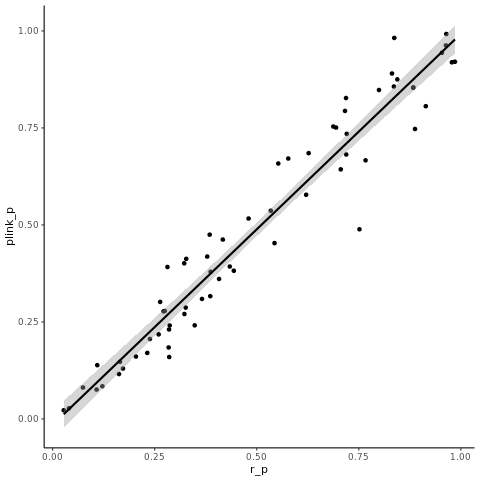

In [48]:
%%R
print("Observa la alta correlacion en un plot")

r <- round(cor(datos_unidos$plink_p, datos_unidos$r_p), 2)
p <- cor.test(datos_unidos$plink_p, datos_unidos$r_p)$p.value
ggplot2::ggplot(datos_unidos, aes(y=plink_p, x=r_p)) + 
  geom_point() + 
  geom_smooth(method="lm", col="black") + 
  theme_classic() 

## Visualizar los resultados

Vamos a ver un archivo de GWAS...    
De esta manera, vamos a poder ver el manhattan plot usando la libreria de R qqman

In [51]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORKSPACE_BUCKET}/rreal-gwas /home/jupyter/workdir_GWAS/')

Executing: gsutil -mu terra-61e6143b cp -r gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/rreal-gwas /home/jupyter/workdir_GWAS/
Copying gs://fc-secure-0b3bd9f2-17a9-4e2b-91f6-53c11325da24/rreal-gwas/RREAL_COGNITIVE_HG38.txt.gz...
| [1/1 files][138.2 MiB/138.2 MiB] 100% Done                                    
Operation completed over 1 objects/138.2 MiB.                                    


In [52]:
%%R
gwas_datos = read.table(gzfile("/home/jupyter/workdir_GWAS/rreal-gwas/RREAL_COGNITIVE_HG38.txt.gz"),
                       header = T)
#gwas_datos = fread("/home/jupyter/workdir_GWAS/rreal-gwas/RREAL_COGNITIVE_HG38.txt.gz")
head(gwas_datos)

                 SNP   CHR       BP A1 A2    maf    beta        HR     se
1 chr19:44908684:T:C chr19 44908684  T  C 0.1377  0.8810 2.4133118 0.1112
2 chr19:44912678:G:T chr19 44912678  T  G 0.8866 -0.9105 0.4023230 0.1211
3 chr19:44912456:G:A chr19 44912456  A  G 0.8866 -0.9105 0.4023230 0.1211
4 chr19:44906745:G:A chr19 44906745  A  G 0.8873 -0.8888 0.4111488 0.1215
5 chr19:44918903:C:G chr19 44918903  C  G 0.1716  0.7482 2.1131928 0.1030
6 chr19:44919689:A:G chr19 44919689  A  G 0.1718  0.7464 2.1093925 0.1031
          P    N
1 2.316e-15 3923
2 5.437e-14 3923
3 5.437e-14 3923
4 2.557e-13 3923
5 3.791e-13 3923
6 4.450e-13 3923


### Procesar los datos de GWAS

In [53]:
%%R
gwas_datos$CHR = as.numeric(gsub("chr","", gwas_datos$CHR))
str(gwas_datos)

'data.frame':	5842576 obs. of  11 variables:
 $ SNP : chr  "chr19:44908684:T:C" "chr19:44912678:G:T" "chr19:44912456:G:A" "chr19:44906745:G:A" ...
 $ CHR : num  19 19 19 19 19 19 19 19 19 19 ...
 $ BP  : int  44908684 44912678 44912456 44906745 44918903 44919689 44919589 44888997 44924977 44892962 ...
 $ A1  : chr  "T" "T" "A" "A" ...
 $ A2  : chr  "C" "G" "G" "G" ...
 $ maf : num  0.138 0.887 0.887 0.887 0.172 ...
 $ beta: num  0.881 -0.91 -0.91 -0.889 0.748 ...
 $ HR  : num  2.413 0.402 0.402 0.411 2.113 ...
 $ se  : num  0.111 0.121 0.121 0.121 0.103 ...
 $ P   : num  2.32e-15 5.44e-14 5.44e-14 2.56e-13 3.79e-13 ...
 $ N   : int  3923 3923 3923 3923 3923 3923 3923 3923 3923 3923 ...


###  Manhattan y Q-Q plot

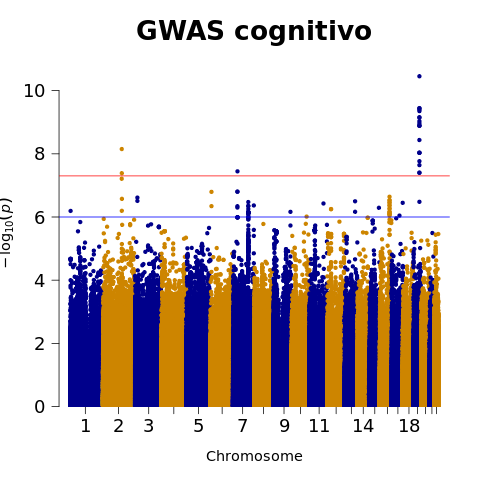

In [54]:
%%R
qqman::manhattan(gwas_datos, chr="CHR", bp="BP", snp="SNP", p="P",
          col = c("blue4", "orange3"),  ylim = c(0, -log10(1e-11)),
          chrlabs = NULL, suggestiveline= -log10(1e-6), 
          genomewideline = -log10(5e-08), highlight = NULL, 
          logp = TRUE, annotatePval = FALSE, 
          annotateTop = FALSE, main='GWAS cognitivo',
          cex.lab=1.2, cex.axis=1.5, cex.main = 2.2)

In [ ]:
%%R
qqman::qq(gwas_datos$P, 
         main = "QQ plot de GWAS conigitivo",
         cex.lab=1.2, cex.axis=1.5, cex.main = 2.2)